### File used to generate unforced trajectories, for comparison between learned and true dynamics

In [1]:
import torch
import sys
import os
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.cm as cm
import scipy
from datetime import datetime
import json

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
	sys.path.insert(0, module_path)
print(sys.path)

import Double_Pendulum.Learning.autoencoders as autoencoders
import Double_Pendulum.robot_parameters as robot_parameters
import Double_Pendulum.transforms as transforms
import Double_Pendulum.dynamics as dynamics
import Plotting.pendulum_plot as pendulum_plot

import matplotlib
matplotlib.rcParams['font.family']   = 'serif'
matplotlib.rcParams['font.serif']    = ['Times New Roman']
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'

from functools import partial



%load_ext autoreload
%autoreload 2


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

['/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code', '/home/kian/anaconda3/envs/thesis2/lib/python311.zip', '/home/kian/anaconda3/envs/thesis2/lib/python3.11', '/home/kian/anaconda3/envs/thesis2/lib/python3.11/lib-dynload', '', '/home/kian/anaconda3/envs/thesis2/lib/python3.11/site-packages']


#### Starting parameters

In [2]:
rp = robot_parameters.LUMPED_PARAMETERS.copy()
#rp["m0"] = 0.
plotter = pendulum_plot.Anim_plotter(rp)
neural_net = False
model_cw = False
model_shifting = True
print(rp["m0"])
print(rp)

armlen = rp["l0"] + rp["l1"]

q0_max = 0.

0.0
{'l0': 2.5, 'l1': 2.5, 'm0': 0.0, 'm1': 3.0, 'g': 9.81, 'xa': 2.0, 'ya': 5}


In [3]:
t_start = 0.
t_end = 3.
dt = 0.01

model = autoencoders.Autoencoder_double(rp).to(device)
model_location = 'Models/NN_optimal/NN_0.pth'
model.load_state_dict(torch.load(model_location, weights_only=True))

<All keys matched successfully>

In [4]:
def ik_fn(xy):
	return transforms.inverse_kinematics(xy, rp, model_cw).squeeze(0)

#### Generate $q$-space trajectory

In [5]:
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [6]:
def sim_q(t_start, t_end, dt, q_start, q_d_start, u):
	q = q_start
	q_d = q_d_start
	qs_ana = []
	q_ds_ana = []


	n_steps = int((t_end - t_start) / dt)

	for _ in range(n_steps):
		
		M_q, C_q, G_q = dynamics.dynamical_matrices(rp, q.squeeze(0), q_d.squeeze(0))
		A_q = dynamics.input_matrix(rp, q.squeeze(0))

		tau_q = A_q * u
		q_dd = (torch.pinverse(M_q) @ (tau_q - C_q @ q_d.T - G_q)).T
		q_d = q_d + q_dd * dt
		q = q + q_d * dt
		
		qs_ana.append(q.squeeze(0).detach())
		q_ds_ana.append(q_d.squeeze(0).detach())
	
	return torch.stack(qs_ana,  dim=0), torch.stack(q_ds_ana, dim=0)

#### Generate $\hat{q}$-space trajectory

In [7]:
timestamp_alt = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

def sim_q_hat(t_start, t_end, dt, q_start, q_d_start, u, model):
	q_nn = q_start
	q_d_nn = q_d_start

	th = model.encoder_vmap(q_nn)
	th_d = (model.jacobian_enc(q_nn) @ q_d_nn.T).T

	q_nn_series, q_d_nn_series = torch.empty((0,2)).to(device), torch.empty((0,2)).to(device)

	for t in torch.arange(t_start, t_end, dt):

		

		is_clockwise = transforms.check_clockwise(q_nn.squeeze(0))

		if model_shifting:
			q_nn = transforms.shift_q(q_nn, clockwise=model_cw)


		
		q_hat = model.decoder_vmap(th, clockwise=model_cw)
		q_d_hat = (model.jacobian_dec(th) @ th_d.T).T
		

		M_q_hat, C_q_hat, G_q_hat = dynamics.dynamical_matrices(rp, q_hat.squeeze(0), q_d_hat.squeeze(0))
		A_q_hat = dynamics.input_matrix(rp, q_hat.squeeze(0))
		J_h_inv = model.jacobian_dec(th, is_clockwise).squeeze(0)
		J_h_inv_trans = torch.transpose(J_h_inv, 0, 1)
		M_th, C_th, G_th = transforms.transform_dynamical_from_inverse(M_q_hat, C_q_hat, G_q_hat, th, th_d, J_h_inv, J_h_inv_trans)
		
		A_th = transforms.transform_input_matrix_from_inverse_trans(A_q_hat, J_h_inv_trans)
		
		tau_th = A_th * u
		th_dd = (torch.pinverse(M_th) @ (tau_th - C_th @ th_d.T - G_th)).T
		th_d = th_d + th_dd * dt
		th = th + th_d * dt
		

		
		q_nn = model.decoder_vmap(th)
		q_d_nn = (model.jacobian_dec(th) @ th_d.T).T
		

		q_nn_series = torch.cat((q_nn_series, q_nn.detach()), dim = 0)
		q_d_nn_series = torch.cat((q_d_nn_series, q_d_nn.detach()), dim = 0)

	return q_nn_series, q_d_nn_series


In [8]:
def make_xy_ana_series(q_ana_series):

	xy_ana_series = torch.empty((0,2)).to(device)
	
	for q_ana in q_ana_series:
		xy_ana, _ = transforms.forward_kinematics(rp, q_ana)
		xy_ana_series = torch.cat((xy_ana_series, xy_ana.unsqueeze(0)))
	
	return xy_ana_series

def make_xy_nn_series(q_nn_series):

	xy_nn_series = torch.empty((0,2)).to(device)

	for q_nn in q_nn_series:
		xy_nn, _ = transforms.forward_kinematics(rp, q_nn)
		xy_nn_series = torch.cat((xy_nn_series, xy_nn.unsqueeze(0)))

	return xy_nn_series


In [9]:
def check_stretched_arm_index(xy_series, arm_length):
	range_series = torch.sqrt(torch.sum(torch.square(xy_series), dim=1))
	too_long = range_series > 0.95 * arm_length
	if too_long.any():
		idxs = torch.nonzero(too_long, as_tuple=True)[0]
		too_long_idx = idxs[0].item()
		return too_long_idx
	else:
		return xy_series.size(0)
	
def check_q_outside_index(q_series, q0_max):
	outside = (q_series[:, 0] > q0_max) | (q_series[:, 0] < -torch.pi)

	if outside.any():
		idxs = torch.nonzero(outside, as_tuple=True)[0]
		outside_idx = idxs[0].item()
		return outside_idx
	else:
		return q_series.size(0)
	
def check_origin_close(xy_series, arm_length):
	range_series = torch.sqrt(torch.sum(torch.square(xy_series), dim=1))
	too_short = range_series < 0.1 * arm_length
	if too_short.any():
		idxs = torch.nonzero(too_short, as_tuple=True)[0]
		too_long_idx = idxs[0].item()
		return too_long_idx
	else:
		return xy_series.size(0)

In [10]:
def create_data_lists(qs_start, q_ds_start, us, loaded_data = None, print_iter = None, save_path = None):

	arm_length = rp["l0"] + rp["l1"]

	if loaded_data is None:
		q_ana_series_list, q_d_ana_series_list, xy_ana_series_list = [], [], []
		q_nn_series_list, q_d_nn_series_list, xy_nn_series_list = [], [], []
	else:
		q_ana_series_list, q_d_ana_series_list, xy_ana_series_list = loaded_data["q_ana_sl"], loaded_data["q_d_ana_sl"], loaded_data["xy_ana_sl"]
		q_nn_series_list, q_d_nn_series_list, xy_nn_series_list = loaded_data["q_nn_sl"], loaded_data["q_d_nn_sl"], loaded_data["xy_nn_sl"]


	for i, (q_start, q_d_start, u) in enumerate(zip(qs_start, q_ds_start, us)):
		if print_iter is not None:
			if i % print_iter == 0:
				print("sim nr:", i)


		# Simulate ANALYTIC trajectory
		q_ana_series, q_d_ana_series = sim_q(t_start, t_end, dt, q_start.clone(), q_d_start.clone(), u)
		

		xy_ana_series = make_xy_ana_series(q_ana_series)

		# Check for exclusion criteria, trim based on most stringent one
		too_long_idx = check_stretched_arm_index(xy_ana_series, arm_length)
		q_outside_idx = check_q_outside_index(q_ana_series, q0_max)
		too_short_idx = check_origin_close(xy_ana_series, arm_length)
		save_idx = min(too_long_idx, q_outside_idx, too_short_idx)
		
		if save_idx > 0:

			# Only simulate NEURAL NETWORK trajectory if analytic makes it the whole way
			q_nn_series, q_d_nn_series = sim_q_hat(t_start, t_end, dt, q_start.clone(), q_d_start.clone(), u, model)
			xy_nn_series = make_xy_nn_series(q_nn_series)

			q_ana_series_list.append(q_ana_series[:save_idx])
			q_d_ana_series_list.append(q_d_ana_series[:save_idx])
			xy_ana_series_list.append(xy_ana_series[:save_idx])

			q_nn_series_list.append(q_nn_series[:save_idx])
			q_d_nn_series_list.append(q_d_nn_series[:save_idx])
			xy_nn_series_list.append(xy_nn_series[:save_idx])

		if save_path is not None:
			data_to_save = {
				"q_ana_sl": q_ana_series_list,
				"q_d_ana_sl": q_d_ana_series_list,
				"xy_ana_sl": xy_ana_series_list,
				"q_nn_sl": q_nn_series_list,
				"q_d_nn_sl": q_d_nn_series_list,
				"xy_nn_sl": xy_nn_series_list,
			}
			torch.save(data_to_save, save_path)
	
	return q_ana_series_list, q_d_ana_series_list, xy_ana_series_list, q_nn_series_list, q_d_nn_series_list, xy_nn_series_list

In [11]:
def make_anim(q_ana_series, q_nn_series, save_dir):
	stride = 3
	pos_end_q_ana, pos_elbow_q_ana = torch.vmap(transforms.forward_kinematics, in_dims=(None, 0))(rp, q_ana_series[::stride])
	pos_end_q_nn, pos_elbow_q_nn = torch.vmap(transforms.forward_kinematics, in_dims=(None, 0))(rp, q_nn_series[::stride])

	frames_q_ana = plotter.frame_pendulum(pos_end_q_ana, pos_elbow_q_ana)
	frames_q_nn = plotter.frame_pendulum(pos_end_q_nn, pos_elbow_q_nn)

	data_ana = {
		"frames": frames_q_ana,
		"times": dt,
		"name": "q_ana", 
		"arm_color": "tab:blue",
		"act_color": "tab:cyan"
	}

	data_nn = {
		"frames": frames_q_nn,
		"times": dt,
		"name": "q_est",
		"arm_color": "tab:orange", 
		"act_color": "tab:red"
	} 


	frames_data = [data_ana, data_nn]

	name_rp = "RP:(" + str(rp["xa"]) + "," + str(rp["ya"]) + ")_"


	if neural_net:
		model_type = "NN"
	else:
		model_type = "AL"

	file_name = "t_end:[" + str(t_end) + "]_dt:[" + str(dt) + "]_stride:[" + str(stride) + "]_0.mp4"
	#file_counter = 0

	output_path = os.path.join(save_dir, file_name)

	while os.path.isfile(output_path):
		print("file name already exists")
		file_counter += 1
		file_name = file_name[:-6] + "_" + str(file_counter) + ".mp4"
		output_path = os.path.join(save_dir, file_name)

	#plotter.animate_pendulum(frames_data, ref_poss=None, plot_actuator=False, save_path=output_path, fps = 1/(dt*stride), dt = dt*stride)


In [23]:
def create_plot_datasets(q_ana_series, q_nn_series, xy_ana_series, xy_nn_series):
	datasets_q = [
		{
			"name": "Learned",
			"values": q_nn_series.cpu().detach().numpy(),
			"color": "tab:orange",
			"style": "solid"
		},
		{
			"name": "Ground truth",
			"values": q_ana_series.cpu().detach().numpy(),
			"color": "tab:blue",
			"style": "solid"
		}
	]

	datasets_xy = [
		{
			"name": "Learned",
			"values": xy_nn_series.cpu().detach().numpy(),
			"color": "tab:orange",
			"style": "solid"
		},
		{
			"name": "Ground truth",
			"values": xy_ana_series.cpu().detach().numpy(),
			"color": "tab:blue",
			"style": "solid"
		}
	]


	# Common labels for the plots.
	name_q = "q trajectory"
	name_xy = "xy trajectory"
	t_series = torch.arange(0, t_end, dt)
	t_series = t_series[:q_ana_series.size(0)]

	# Create an instance of ErrorPlotter.
	ep = pendulum_plot.Error_plotter(rp)

	# Prepare plot datasets for each column.
	# Each call groups a set of datasets to be drawn in one subplot column.
	q_plot_dataset = ep.create_plot_dataset(t=t_series, datasets=datasets_q, reference=None, name=name_q)
	xy_plot_dataset = ep.create_plot_dataset(t=t_series, datasets=datasets_xy, reference=None, name=name_xy)


	plot_datasets = [q_plot_dataset, xy_plot_dataset]
	plot_colormaps = ["Oranges", "Blues", "Greens"]

	return plot_datasets, plot_colormaps

In [13]:

def make_error_plots(plot_datasets, save_dir, ep):
	file_name = "Error plot.png"
	file_counter = 0

	output_path = os.path.join(save_dir, file_name)

	# Pass the list of columns (plot_dataset objects) to plot_multi.
	ep.plot_multi(plot_datasets=plot_datasets, save_path=output_path, axes_names = ["q", "th", "xy"])




#### Plot $q$-space error

In [ ]:
from matplotlib.lines import Line2D
def plot_q_trajs(q_dataset, plot_colormaps, save_dir, plotter_counter):
	fig, ax = plt.subplots(figsize=(6,4))
	scs = []
	for i, cmap in zip(range(2), plot_colormaps):
		t = q_dataset["x"]                      # shape (N,)
		q1 = q_dataset["data"][i]["y1"]         # shape (N,)
		q2 = q_dataset["data"][i]["y2"]         # shape (N,)
		sc = ax.scatter(q1, q2, c=t, cmap=cmap, s=20)

		# optionally connect points in order
		ax.plot(q1, q2, lw=0.5, color='gray', alpha=0.5)
		scs.append(sc)

	# labels and colorbar
	ax.set_xlabel('$q_0$' + " " + r"$(rad)$")
	ax.set_ylabel('$q_1$' + " " + r"$(rad)$")
	ax.grid()

	cbar1 = fig.colorbar(
		scs[0], ax=ax, pad=-0.01, fraction=0.057
	)
	cbar1.set_label('time')

	cbar2 = fig.colorbar(
		scs[1], ax=ax, pad=0.02, fraction=0.057, ticks=[]
	)

	labels = [q_dataset["data"][i]["name"] for i in range(2)]
	proxies = []
	for cmap, label in zip(plot_colormaps, labels):
		color = plt.get_cmap(cmap)(0.7)
		proxies.append(Line2D([0], [0], marker='o', 
							  color='w',
							  markerfacecolor=color,
							  markersize=8, 
							  linestyle='',
							  label=label))

	ax.legend(handles=proxies, title="Trajectories")

	ax.set_title('Trajectory in $(q_0,q_1)$ colored by time')
	plt.tight_layout()
	plt.savefig(save_dir + "/curves" + "/q-curve_" + str(plotter_counter) + ".pdf")
	plt.show()

In [ ]:
def plot_xy_trajs(xy_dataset, plot_colormaps, save_dir, plotter_counter):
	fig, ax = plt.subplots(figsize=(5,4))
	scs = []
	for i, cmap in zip(range(2), plot_colormaps):
		t = xy_dataset["x"]
		q1 = xy_dataset["data"][i]["y1"]
		q2 = xy_dataset["data"][i]["y2"]
		sc = ax.scatter(q1, q2, c=t, cmap=cmap, s=20)

		# optionally connect points in order
		ax.plot(q1, q2, lw=0.5, color='gray', alpha=0.5)
		scs.append(sc)

	circ = plt.Circle((0, 0), armlen, color="gray", fill=False, linestyle="dashed", alpha=0.8)
	ax.add_patch(circ)

	# labels and colorbar
	ax.set_xlabel('$x$' + " " + r"$(m)$")
	ax.set_ylabel('$y$' + " " + r"$(m)$")
	ax.grid()

	ax.set_xlim(-armlen, armlen)
	ax.set_ylim(-armlen, armlen)

	cbar1 = fig.colorbar(
		scs[0], ax=ax, pad=-0.0, fraction=0.057
	)
	cbar1.set_label('time')

	cbar2 = fig.colorbar(
		scs[1], ax=ax, pad=-0.14, fraction=0.057, ticks=[]
	)

	labels = [xy_dataset["data"][i]["name"] for i in range(2)]
	proxies = []
	for cmap, label in zip(plot_colormaps, labels):
		color = plt.get_cmap(cmap)(0.7)
		proxies.append(Line2D([0], [0], marker='o', 
							  color='w',
							  markerfacecolor=color,
							  markersize=8, 
							  linestyle='',
							  label=label))

	ax.legend(handles=proxies, title="Trajectories")

	ax.set_title('Trajectory in $(x,y)$ colored by time')
	plt.axis('square')
	plt.tight_layout()
	plt.savefig(save_dir + "/curves" + "/xy-curve_" + str(plotter_counter) + ".pdf")
	plt.show()

In [16]:
n_sims = 5
n_tries = 4 * n_sims
print_iter = max(torch.floor(torch.tensor(n_sims)/100).item(), 1)

#sample_angle = 2 * torch.pi * torch.rand(n_tries)
#sample_radius = 0.6 * armlen * torch.sqrt(torch.rand(n_tries)) + 0.2 * armlen
#xs = sample_radius * torch.cos(sample_angle)
#ys = sample_radius * torch.sin(sample_angle)

xmin, xmax = 1, 3
ymin, ymax = -1, 1
xs = torch.rand(n_tries) * (xmax - xmin) + xmin
ys = torch.rand(n_tries) * (ymax - ymin) + ymin
xys_start = torch.stack((xs, ys), dim=1).requires_grad_().to(device)


x_dmin, x_dmax = -3, 3
y_dmin, y_dmax = -0.5, 0.5
x_ds = torch.rand(n_tries) * (x_dmax - x_dmin) + x_dmin
y_ds = torch.rand(n_tries) * (y_dmax - y_dmin) + y_dmin
xy_ds_start = torch.stack((x_ds, y_ds), dim=1).requires_grad_().to(device)

qs_start = torch.empty((0,2)).requires_grad_().to(device)
q_ds_start = torch.empty((0,2)).requires_grad_().to(device)

for xy_start, xy_d_start in zip(xys_start, xy_ds_start):
	q_start = transforms.inverse_kinematics(xy_start, rp, is_clockwise=model_cw).unsqueeze(0)
	q_d_start = (torch.autograd.functional.jacobian(ik_fn, xy_start) @ xy_d_start).unsqueeze(0)

	qs_start = torch.cat((qs_start, q_start))
	q_ds_start = torch.cat((q_ds_start, q_d_start))

keep_points = qs_start[:, 0] < q0_max

xys_start = xys_start[keep_points][:n_sims]
xy_ds_start = xy_ds_start[keep_points][:n_sims]
qs_start = qs_start[keep_points][:n_sims]
q_ds_start = q_ds_start[keep_points][:n_sims]
qs_start = qs_start.unsqueeze(1)
q_ds_start = q_ds_start.unsqueeze(1)

us = -25 - 10 * torch.rand(n_sims)

#### Load the data (in case you want to append to existing trials)

In [17]:
load_data = False
loaded_data_dir = "Performance_Sims/Optimal"
load_num = 0
if load_data:
	loaded_data = torch.load(loaded_data_dir+"/simulations_data_" + str(load_num) + ".pt")
	print("Loading simulation data from:", loaded_data_dir)
else:
	loaded_data = None
	print("Not loading simulation data.")


Not loading simulation data.


In [18]:
save_dir = "Performance_Sims/Optimal"
save_path = save_dir + "/simulations_data_0.pt"
file_iter = 1
while os.path.isfile(save_path):
    save_path = save_path[:-4] + str(file_iter) + ".pt"
    file_iter += 1

q_ana_sl, q_d_ana_sl, xy_ana_sl, q_nn_sl, q_d_nn_sl, xy_nn_sl = create_data_lists(qs_start, q_ds_start, us, loaded_data = loaded_data, 
																				  print_iter = print_iter, save_path=save_path)

sim nr: 0
sim nr: 1
sim nr: 2
sim nr: 3
sim nr: 4


#### Save the data (also happens during generation)

In [19]:
os.makedirs(save_dir, exist_ok=True)

data_to_save = {
	"q_ana_sl": q_ana_sl,
	"q_d_ana_sl": q_d_ana_sl,	
	"xy_ana_sl": xy_ana_sl,
	"q_nn_sl": q_nn_sl,
	"q_d_nn_sl": q_d_nn_sl,
	"xy_nn_sl": xy_nn_sl,
}

torch.save(data_to_save, save_dir + "/simulations_data_" + str(file_iter) + ".pt")

#### Load the data (in case you're running without generating)

In [25]:
load_data_dir = "Performance_Sims/Optimal"
load_num = 0
loaded_data = torch.load(load_data_dir + "/simulations_data_" + str(load_num) + ".pt")
loaded_data = torch.load(load_data_dir + "/simulations_data backup.pt")

q_ana_sl = loaded_data["q_ana_sl"]
q_d_ana_sl = loaded_data["q_d_ana_sl"]
xy_ana_sl = loaded_data["xy_ana_sl"]
q_nn_sl = loaded_data["q_nn_sl"]
q_d_nn_sl = loaded_data["q_d_nn_sl"]
xy_nn_sl = loaded_data["xy_nn_sl"]

/tmp/ipykernel_12221/1903611054.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load(load_data_dir + "/simulations_data_" + str(load_num) + ".pt")
/t

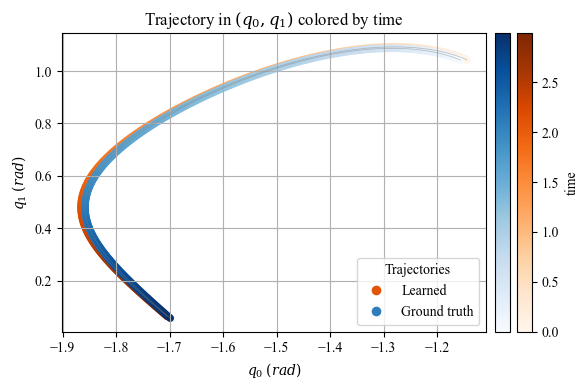

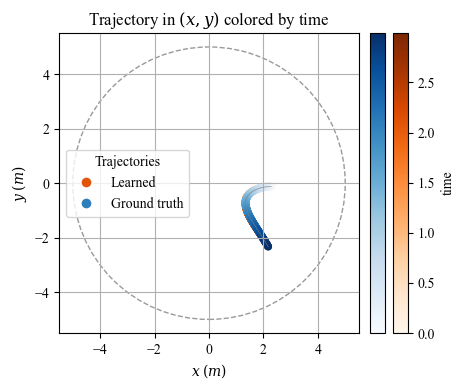

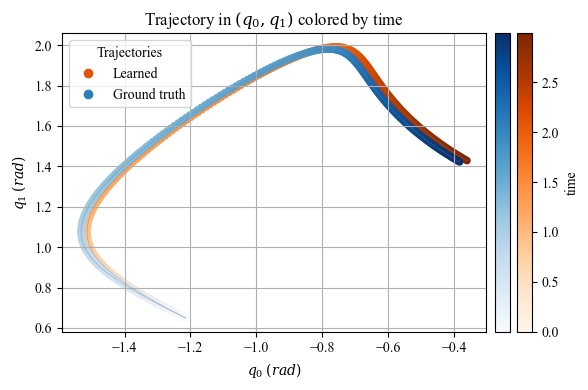

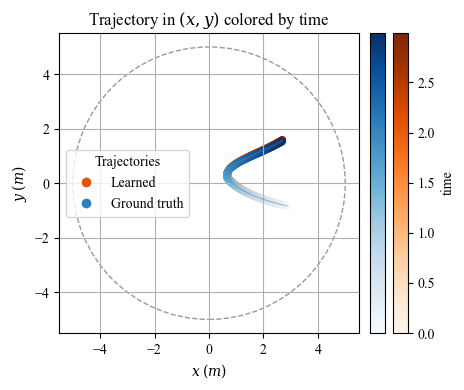

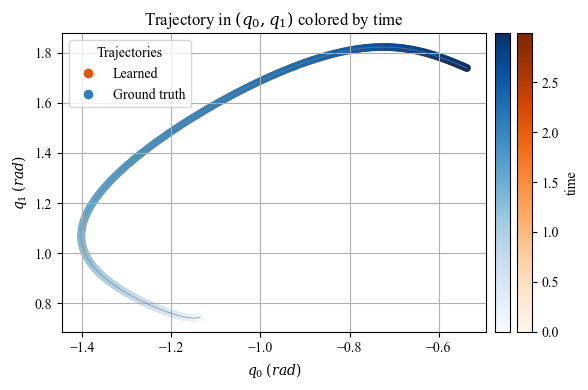

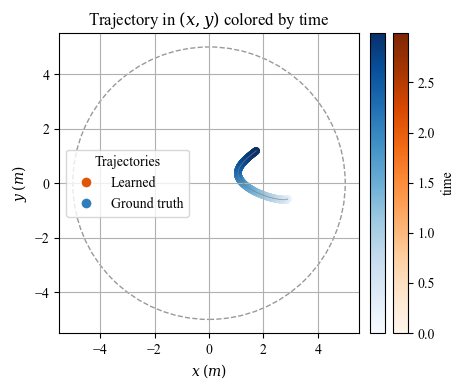

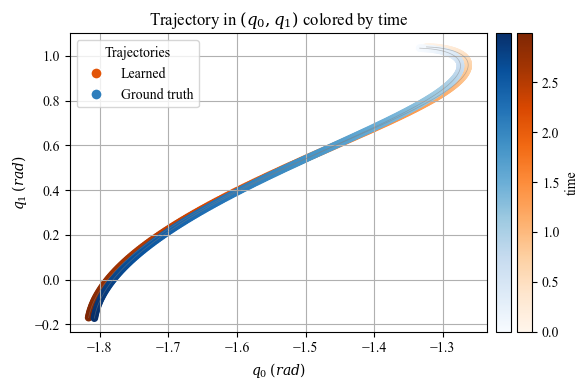

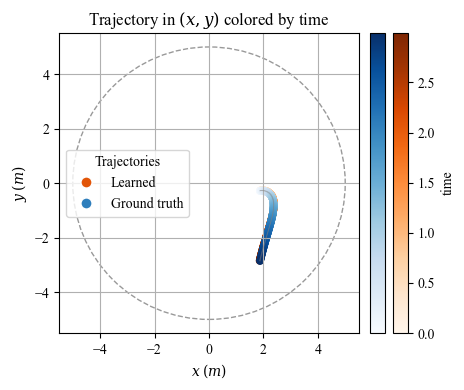

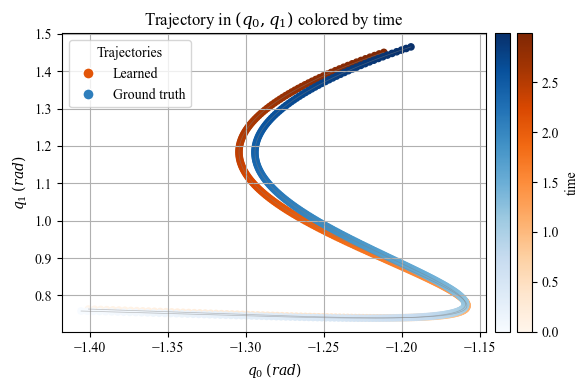

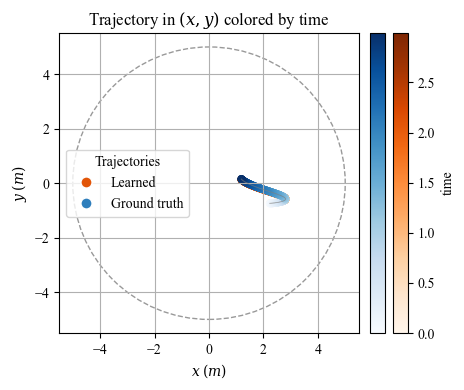

In [ ]:
q_error_list = []
xy_error_list = []

plotter_counter = 0
for i, (qas, qdas, xyas, qns, qdns, xyns) in enumerate(zip(q_ana_sl, q_d_ana_sl, xy_ana_sl, q_nn_sl, q_d_nn_sl, xy_nn_sl)):

	q_error_series = qas - qns
	q_d_error_series = qdas - qdns
	xy_error_series = xyas - xyns
	plot_datasets, plot_colormaps = create_plot_datasets(qas, qns, xyas, xyns)
	q_plot_dataset = plot_datasets[0]
	xy_plot_dataset = plot_datasets[1]
	if qas.size(0) == 300:
		q_error_list.append(q_error_series)
		xy_error_list.append(xy_error_series)

		if plotter_counter < 5:
			plot_q_trajs(q_plot_dataset, plot_colormaps, save_dir, plotter_counter)
			plot_xy_trajs(xy_plot_dataset, plot_colormaps, save_dir, plotter_counter)
			plotter_counter += 1




In [ ]:
# Number of trials that made it to the end
print(len(q_error_list))

In [ ]:
# Transform the q_error_list into a pytorch tensor
q_error_list_full = torch.nn.utils.rnn.pad_sequence(q_error_list, batch_first = True, padding_value=float("nan"))

# Calculate the sample mean
q_error_mean = torch.nanmean(q_error_list_full, dim=0)

# Calculate the rmse error manually
q_error_square = torch.square(q_error_list_full)
q_error_mse = torch.nanmean(q_error_square, dim=0)
q_error_rmse = torch.sqrt(q_error_mse)

# Create mask which is True where index is NOT nan
nan_mask = ~torch.isnan(q_error_list_full)
# Log how many of the trials are not nan at each time step
counts = nan_mask.sum(dim=(0))[:,0]

# Calculate the sample standard deviation manually
q_error_diff = q_error_list_full - q_error_mean
q_error_sqdiff = torch.square(q_error_diff)
q_error_sumsqdiff = torch.nansum(q_error_sqdiff, dim=0)
q_error_var = q_error_sumsqdiff / (counts-1).unsqueeze(1)
q_error_std = torch.sqrt(q_error_var)

In [ ]:
def calc_rmse(error_list):
	error_list_full = torch.nn.utils.rnn.pad_sequence(error_list, batch_first = True, padding_value=float("nan"))
	error_square = torch.square(error_list_full)
	error_mse = torch.nanmean(error_square, dim=0)
	error_rmse = torch.sqrt(error_mse)
	return error_rmse

def calc_std(error_list):
	error_list_full = torch.nn.utils.rnn.pad_sequence(error_list, batch_first = True, padding_value=float("nan"))
	error_mean = torch.nanmean(error_list_full, dim=0)
	nan_mask = ~torch.isnan(error_list_full)
	counts = nan_mask.sum(dim=(0))[:,0]
	error_diff = error_list_full - error_mean
	error_sqdiff = torch.square(error_diff)
	error_sumsqdiff = torch.nansum(error_sqdiff, dim=0)
	error_var = error_sumsqdiff / (counts-1).unsqueeze(1)
	error_std = torch.sqrt(error_var)
	return error_std

In [ ]:
xy_error_rmse = calc_rmse(xy_error_list)
xy_error_std = calc_std(xy_error_list)

In [ ]:
def plot_error_std(error_rmse, error_std, ylim, y1label, y2label, yaxislabel, title_string, save_dir, file_name):
	t = torch.arange(error_rmse.size(0))/100

	y = error_rmse.cpu().detach().numpy()
	ystd = error_std.cpu().detach().numpy()

	fig, ax = plt.subplots(figsize=(5, 2.5))

	# Plot each column with shaded std area
	colors = ["C0", "C1"]
	for i, label in enumerate([y1label, y2label]):
		ax.plot(t, y[:, i], label=label, color = colors[i], linewidth = 2.5)
		ax.fill_between(
			t,
			(y[:, i] - ystd[:, i]),
			(y[:, i] + ystd[:, i]),
			alpha=0.1,
			color = colors[i]
		)
		ax.plot(t, (y[:, i] - ystd[:, i]), linestyle="--", color = colors[i], alpha = 0.5)
		ax.plot(t, (y[:, i] + ystd[:, i]), linestyle="--", color = colors[i], alpha = 0.5)

	ax.set_xlabel('time (s)')
	ax.set_ylabel(yaxislabel)
	ax.set_title('Learned dynamics prediction error, ' + title_string)
	ax.set_ylim(ylim)
	ax.set_xlim((0, error_rmse.size(0)/100))
	ax.legend()
	ax.grid()
	plt.tight_layout()
	plt.savefig(save_dir + file_name +".pdf", format="pdf")
	plt.show()
	


In [ ]:

plot_error_std(q_error_rmse, q_error_std, (0, 0.2), r"$q_0$", r"$q_1$", "RMSE (rad)", "joint angles " + r"$q$", save_dir, "/Dynamics_prediction_error_q")
plot_error_std(xy_error_rmse, xy_error_std, (0, 0.4), "x", "y", "RMSE (m)", "end-effector position " + r"$(x,y)$", save_dir, "/Dynamics_prediction_error_xy")